In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sails.wavelet
from neurodsp.filt import filter_signal
from sails import wavelet
import scipy.stats as stats
import emd
import tarfile
import io
from scipy import signal
from scipy import stats
from scipy import fftpack
from sympy.stats.sampling.sample_scipy import scipy
from tqdm import tqdm
from icecream import ic
import neurodsp.filt as dsp
import seaborn as sns
from skimage.feature import peak_local_max

# Directories
Set the working directory as well as access to the main LFP dataset and supplementary dataset

In [2]:
# Set the current working directory
cwd = os.chdir(r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz")

# Access to the Steinmetz LFP dataset
lfp_dat = r"E:\Steinmetz_Dataset"

# @title Data retrieval
data_directory = r'data\spikeAndBehavioralData'

In [3]:
print(os.path.join(os.getcwd(),data_directory))

C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData


## Brain Regions of Interest

In [4]:
hpc = ["CA1", "CA3", "DG", "SUB"]
pfc = ["ACA", "ILA", "PL","RSP"]
region_loop = hpc + pfc

## Power spectrum functions

In [5]:
def plot_power_spectrum(data, fs, nperseg=1024, noverlap=None, scaling='density', ax=None):
    """
    Plot the power spectrum of a given signal.

    Parameters:
    - data: array-like, the time series data
    - fs: float, the sampling frequency (in Hz)
    - nperseg: int, length of each segment for Welch's method (default 1024)
    - noverlap: int, number of points to overlap between segments (default None)
    - scaling: str, 'density' for PSD, 'spectrum' for power spectrum (default 'density')
    - ax: matplotlib axis object, if None a new figure is created

    Returns:
    - fig: matplotlib figure object
    - ax: matplotlib axis object
    """
    
    # Compute the power spectrum
    frequencies, psd = signal.welch(data, fs=fs, nperseg=nperseg, noverlap=noverlap, scaling=scaling)
    
    # Create a new figure if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig = ax.figure
    
    # Plot the power spectrum
    ax.semilogy(frequencies, psd)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power/Frequency' if scaling == 'density' else 'Power')
    ax.set_title('Power Spectrum' if scaling == 'spectrum' else 'Power Spectral Density')
    ax.grid(True)
    
    return fig, ax

In [6]:
   def analyze_channel_spectrum(signal_data, sampling_rate):
       N = len(signal_data)
       
       # Compute the FFT
       yf = signal.fft(signal_data)
       xf = signal.fftfreq(N, 1 / sampling_rate)
       
       # Compute the power spectrum
       power_spectrum = np.abs(yf)**2
       
       # Plot the power spectrum
       plt.figure(figsize=(10, 6))
       plt.plot(xf[:N//2], power_spectrum[:N//2])
       plt.xlabel('Frequency (Hz)')
       plt.ylabel('Power')
       plt.title('Power Spectrum')
       plt.grid(True)
       plt.show()

### Defining file iterator (for later use)

In [7]:
walker = os.walk(os.path.join(os.getcwd(),data_directory))
for root, dirs, files in walker:
    print(root)
    print(dirs)
    print(files)

C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData
['Cori_2016-12-18']
['Cori_2016-12-14.tar', 'Cori_2016-12-17.tar', 'Cori_2016-12-18.tar', 'Forssmann_2017-11-01.tar', 'Forssmann_2017-11-02.tar', 'Forssmann_2017-11-04.tar', 'Forssmann_2017-11-05.tar', 'Hench_2017-06-15.tar', 'Hench_2017-06-16.tar', 'Hench_2017-06-17.tar', 'Hench_2017-06-18.tar', 'Lederberg_2017-12-05.tar', 'Lederberg_2017-12-06.tar', 'Lederberg_2017-12-07.tar', 'Lederberg_2017-12-08.tar', 'Lederberg_2017-12-09.tar', 'Lederberg_2017-12-10.tar', 'Lederberg_2017-12-11.tar', 'Moniz_2017-05-15.tar', 'Moniz_2017-05-16.tar', 'Moniz_2017-05-18.tar', 'Muller_2017-01-07.tar', 'Muller_2017-01-08.tar', 'Muller_2017-01-09.tar', 'Radnitz_2017-01-08.tar', 'Radnitz_2017-01-09.tar', 'Radnitz_2017-01-10.tar', 'Radnitz_2017-01-11.tar', 'Radnitz_2017-01-12.tar', 'Richards_2017-10-29.tar', 'Richards_2017-10-30.tar', 'Richards_2017-10-31.tar', 'Richards_2017-11-01.tar', 'Richards_2017-11-02.tar', 'Tatum_2017

### .npy file loader from tarball

In [8]:
def npy_loader(filename:str)-> np.ndarray:
    '''
    Numpy loader function for .npy in tarball (.tar) packages.
    
    :param filename: str
    :return: np.ndarray 
    '''
    try:
        npy_file = tar.extractfile(filename)
        if npy_file is not None:
            npy_file_content = npy_file.read()
            
            # Check file size to confirm it's not empty or corrupted
            if len(npy_file_content) == 0:
                raise ValueError(f"The .npy file '{filename}' is empty or corrupted.")
            
            # Load .npy file from memory using BytesIO
            np_data = np.load(io.BytesIO(npy_file_content))
            return np_data
        else:
            raise FileNotFoundError(f"Could not find or extract the file: {probe_filename}")
    except Exception as e:
        print(f"Error reading .npy file: {e}")
    

In [9]:
alldata_tar_path = os.path.join(os.getcwd(),data_directory,r"Cori_2016-12-18.tar")
with tarfile.open(alldata_tar_path, 'r') as tar:
    print(tar.getnames())
    
    brain_loc_filename = [name for name in tar.getnames()[:5] if name.endswith('.tsv')][0]
    probe_desc_filename = [name for name in tar.getnames() if name.endswith('rawFilename.tsv')][0]
    probe_filename  = [name for name in tar.getnames() if name.endswith('probe.npy')][0]
    
    brain_loc = pd.read_csv(tar.extractfile(brain_loc_filename), sep='\t')
    probe_desc = pd.read_csv(tar.extractfile(probe_desc_filename), sep='\t')
    
    # # Attempt to extract the .npy file safely
    # try:
    #     npy_file = tar.extractfile(probe_filename)
    #     if npy_file is not None:
    #         npy_file_content = npy_file.read()
    #         
    #         # Check file size to confirm it's not empty or corrupted
    #         if len(npy_file_content) == 0:
    #             raise ValueError(f"The .npy file '{probe_filename}' is empty or corrupted.")
    #         
    #         # Load .npy file from memory using BytesIO
    #         np_data = np.load(io.BytesIO(npy_file_content))
    #         print(np_data)  # Process the numpy data here as needed
    #     else:
    #         raise FileNotFoundError(f"Could not find or extract the file: {probe_filename}")
    # except Exception as e:
    #     print(f"Error reading .npy file: {e}")
    
    

['channels.brainLocation.tsv', 'channels.probe.npy', 'channels.rawRow.npy', 'channels.site.npy', 'channels.sitePositions.npy', 'clusters.depths.npy', 'clusters.originalIDs.npy', 'clusters.peakChannel.npy', 'clusters.probes.npy', 'clusters.templateWaveformChans.npy', 'clusters.templateWaveforms.npy', 'clusters.waveformDuration.npy', 'clusters._phy_annotation.npy', 'Cori_2016-12-18_AM_g0_t0.imec.lf.timestamps.npy', 'Cori_2016-12-18_V1_g0_t0.imec.lf.timestamps.npy', 'eye.area.npy', 'eye.blink.npy', 'eye.timestamps.npy', 'eye.xyPos.npy', 'face.motionEnergy.npy', 'face.timestamps.npy', 'lickPiezo.raw.npy', 'lickPiezo.timestamps.npy', 'licks.times.npy', 'passiveBeeps.times.npy', 'passiveValveClick.times.npy', 'passiveVisual.contrastLeft.npy', 'passiveVisual.contrastRight.npy', 'passiveVisual.times.npy', 'passiveWhiteNoise.times.npy', 'probes.description.tsv', 'probes.insertion.tsv', 'probes.rawFilename.tsv', 'probes.sitePositions.npy', 'sparseNoise.positions.npy', 'sparseNoise.times.npy', 's

In [10]:
brain_loc.shape

(748, 4)

In [11]:
brain_loc.query('allen_ontology == "CA1"')

,ccf_ap,ccf_dv,ccf_lr,allen_ontology
220,7937.6,1669.8,3568.1,CA1
221,7955.5,1650.4,3612.9,CA1
222,7943.8,1631.0,3601.0,CA1
223,7929.0,1631.0,3572.6,CA1
224,7946.9,1611.6,3617.4,CA1
225,7932.1,1611.6,3589.1,CA1
226,7935.2,1592.2,3605.5,CA1
227,7920.4,1592.2,3577.1,CA1
228,7938.2,1572.8,3621.9,CA1
229,7923.4,1572.8,3593.6,CA1


In [12]:
probe_desc

,rawFilename
0,Cori_2016-12-18_AM_g0_t0.imec.ap_CAR.bin
1,Cori_2016-12-18_V1_g0_t0.imec.ap_CAR.bin


In [13]:
probe = np.load(r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData\Cori_2016-12-18\channels.probe.npy", allow_pickle=True)
raw_Row = np.load(r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData\Cori_2016-12-18\channels.rawRow.npy", allow_pickle=True)
site = np.load(r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData\Cori_2016-12-18\channels.site.npy", allow_pickle=True)
site_pos = np.load(r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData\Cori_2016-12-18\channels.sitePositions.npy", allow_pickle=True)

In [14]:
brain_loc['probe'] = probe
brain_loc['site'] = site
brain_loc[['site_pos_x','site_pos_y']] = site_pos
brain_loc['raw_Row'] = raw_Row

In [15]:
brain_loc.query('allen_ontology == "CA1" & probe == 0')

,ccf_ap,ccf_dv,ccf_lr,allen_ontology,probe,site,site_pos_x,site_pos_y,raw_Row
220,7937.6,1669.8,3568.1,CA1,0.0,225,11.0,2260.0,225
221,7955.5,1650.4,3612.9,CA1,0.0,226,59.0,2280.0,226
222,7943.8,1631.0,3601.0,CA1,0.0,228,43.0,2300.0,228
223,7929.0,1631.0,3572.6,CA1,0.0,229,11.0,2300.0,229
224,7946.9,1611.6,3617.4,CA1,0.0,230,59.0,2320.0,230
225,7932.1,1611.6,3589.1,CA1,0.0,231,27.0,2320.0,231
226,7935.2,1592.2,3605.5,CA1,0.0,232,43.0,2340.0,232
227,7920.4,1592.2,3577.1,CA1,0.0,233,11.0,2340.0,233
228,7938.2,1572.8,3621.9,CA1,0.0,234,59.0,2360.0,234
229,7923.4,1572.8,3593.6,CA1,0.0,235,27.0,2360.0,235


## Discovering the Channel Labelling Scheme

<Axes: xlabel='site_pos_x', ylabel='site_pos_y'>

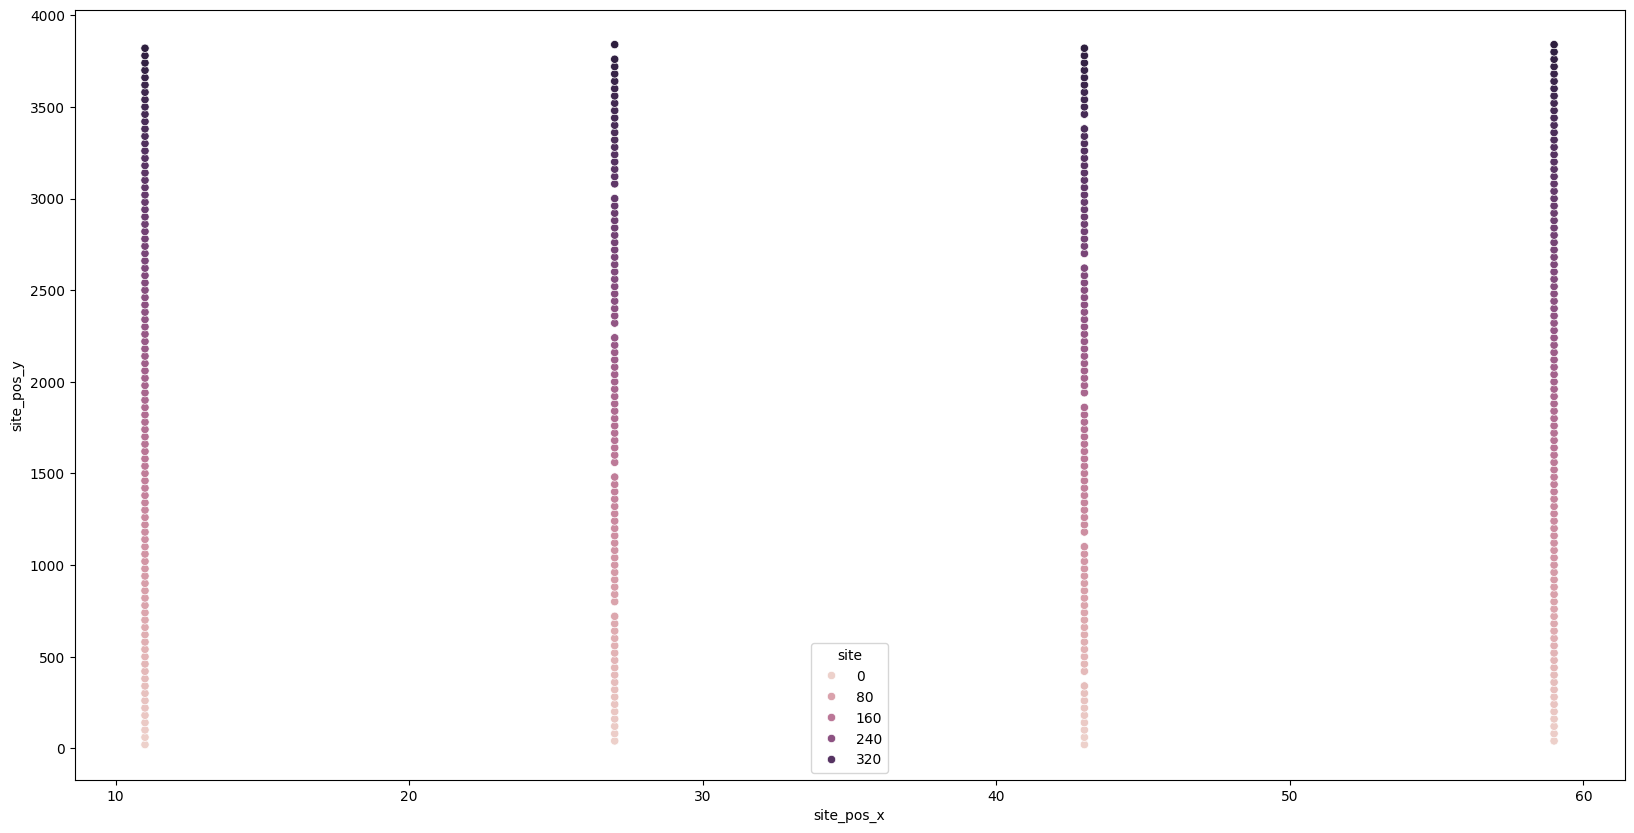

In [16]:
plt.figure(figsize=(20,10))
sns.scatterplot(brain_loc.query('probe == 0'),x='site_pos_x', y='site_pos_y', hue='site')

<Axes: xlabel='site_pos_x', ylabel='site_pos_y'>

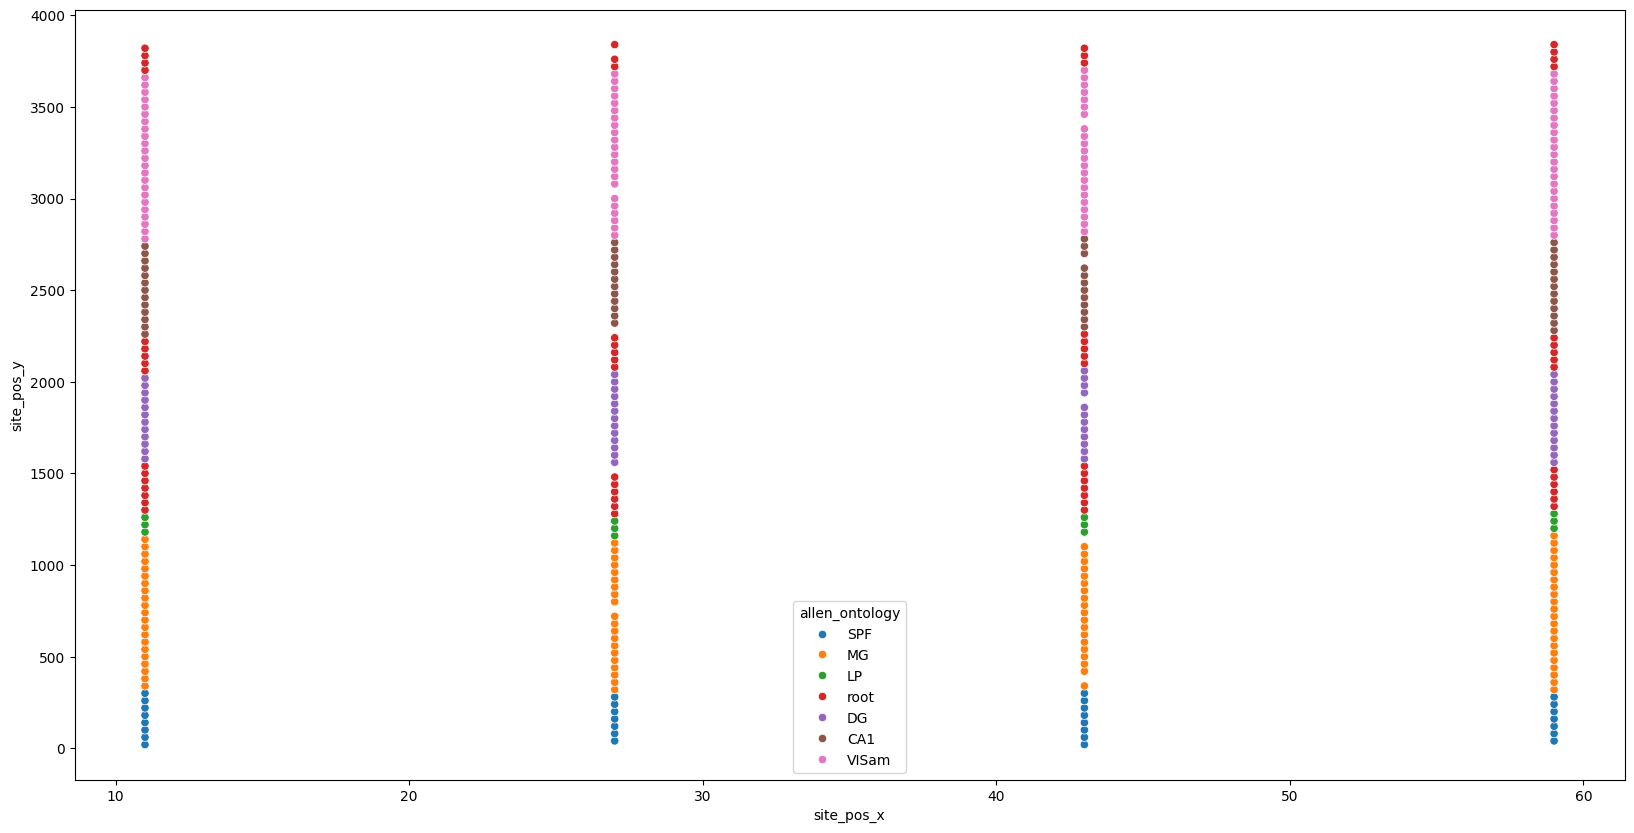

In [17]:
plt.figure(figsize=(20,10))
sns.scatterplot(brain_loc.query('probe == 0'),x='site_pos_x', y='site_pos_y', hue='allen_ontology')

### Probe Selection

Select the necessary probes that have recording sites of our brain regions of interest

In [18]:
# Identify probe for CA1
probe_select = brain_loc.query('allen_ontology == "CA1"')['probe'].unique() == np.array([0,1])

In [19]:
#TODO: Build a dataset loader that interacts with the online database

# Path to your .tar file


tar_path = r"E:\Steinmetz_Dataset\Cori_2016-12-18_lfp.tar"



# Define the parameters based on the documentation
num_channels = 385  # 385 channels as specified
data_type = np.int16  # int16 data type
sampling_rate = 2500  # 2500 Hz sampling rate

# Open the .tar file and load the .bin file
with tarfile.open(tar_path, 'r') as tar:
    # Identify the .bin file (assuming there's only one)
    bin_file_name = np.array(tar.getnames())[probe_select][0]
    
    
    # Extract the .bin file to memory
    bin_file = tar.extractfile(bin_file_name)
    
    # Determine the number of samples by dividing the file size by the number of channels
    # and the size of each data point (2 bytes for int16)
    file_size = tar.getmember(bin_file_name).size
    num_samples = file_size // (num_channels * np.dtype(data_type).itemsize)
    
    # Read the .bin file in chunks if it's too large for memory
    chunk_size = 1000000  # Set a reasonable chunk size
    all_data = []
    
    while True:
        # Read a chunk of data
        data_chunk = np.frombuffer(bin_file.read(chunk_size * num_channels * np.dtype(data_type).itemsize), dtype=data_type)
        if data_chunk.size == 0:
            break
        # Reshape the chunk to (num_channels, chunk_samples)
        data_chunk = data_chunk.reshape(-1, num_channels).T
        all_data.append(data_chunk)
    
    # Concatenate all chunks if the entire data needs to be loaded
    reshaped_data = np.hstack(all_data)

# At this point, reshaped_data contains the LFP data in shape (385, num_total_samples)

In [20]:
ic(reshaped_data.shape)

ic| reshaped_data.shape: (385, 9585948)


(385, 9585948)

## Synchronization Signal Channel
When plotting Channel 385, we can observe that this channel contains our time events of stimulus being presented

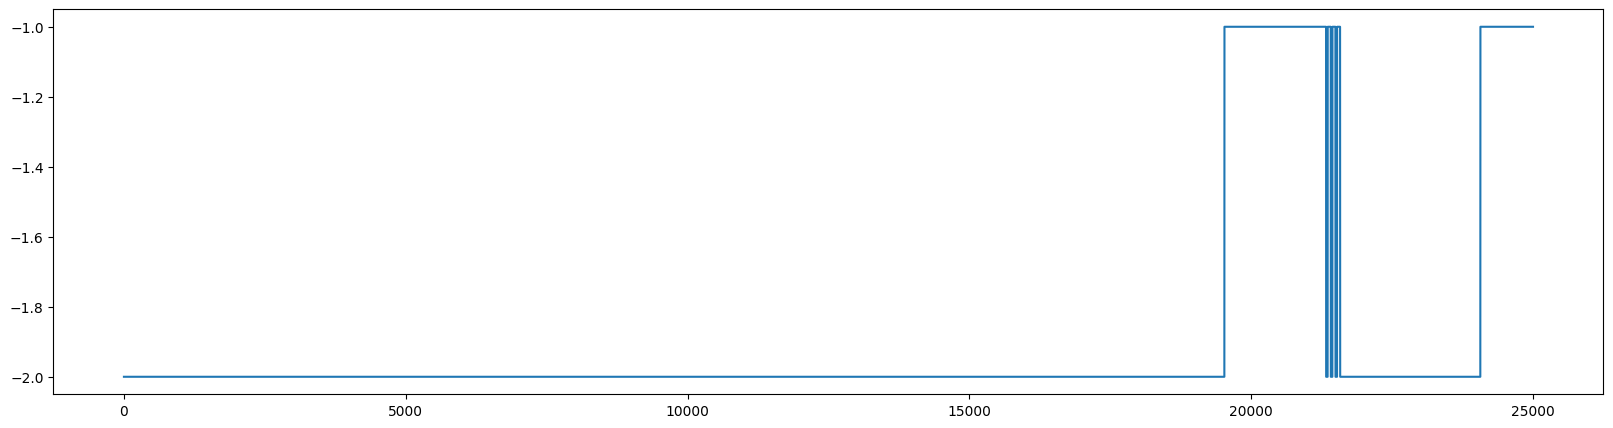

In [21]:
plt.figure(figsize=(20,5))
plt.plot(reshaped_data[-1, 180000:205000]) 

### Plot of a random CA1 channel

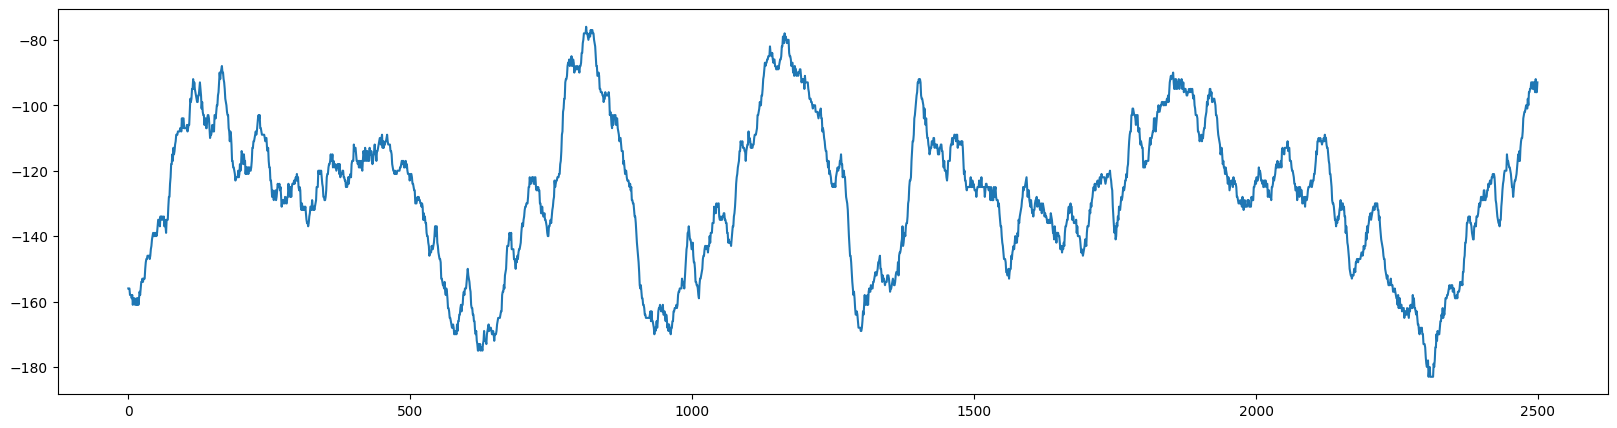

In [22]:
plt.figure(figsize=(20,5))
plt.plot(reshaped_data[233, :2500]) 

### Line Noise
Line Noise is often encountered sourcing from AC sources. If the experiment is done in the EU, line noise can be filtered at 50 Hz and for the US it is 60 Hz. If you're unsure, one can plot a power spectrum below

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Power Spectral Density'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency'>)

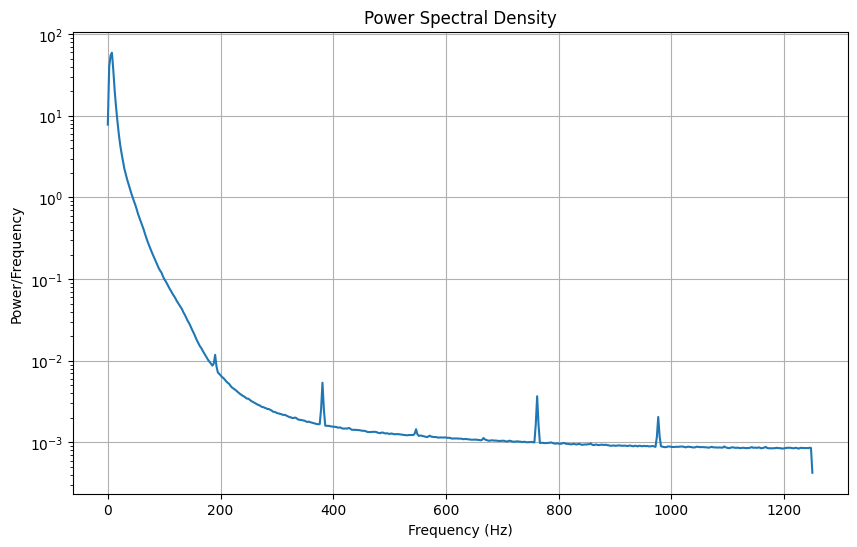

In [23]:
plot_power_spectrum(reshaped_data[233,:],2500)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Power Spectral Density'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency'>)

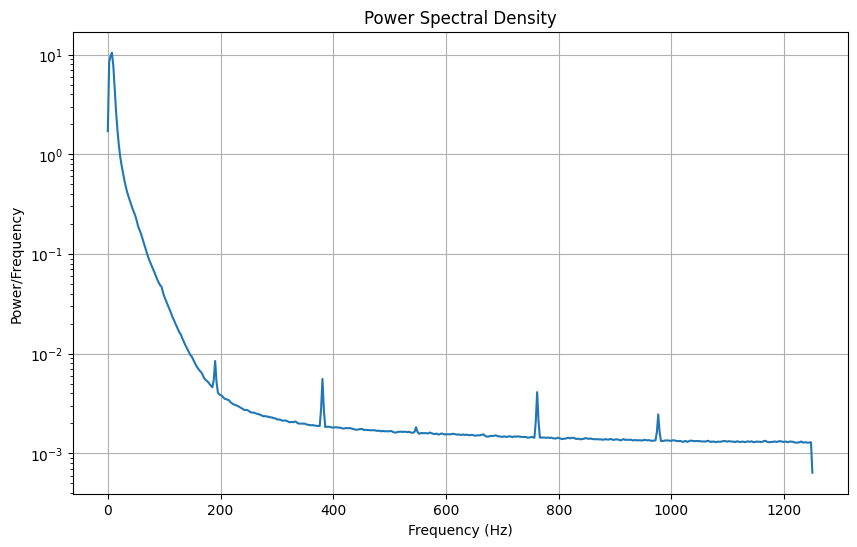

In [24]:
plot_power_spectrum(reshaped_data[0,:],2500)

In [25]:
#TODO: Improve processing speed, split integer and decimal float into two parts. Integer subtraction -> Convert signal to float > Float subtraction
def CAR_filter(signal, mode ='mean'):
    avg_ref = np.zeros((signal.shape[0],1))
    if mode == 'mean':
        avg_ref = np.mean(signal,axis=0)
    if mode == 'median':
        avg_ref = np.median(signal,axis=0)
    return avg_ref

In [26]:
avg_ref = CAR_filter(reshaped_data[:-1], mode='median')

### Selecting regions of interests
We would like to look at CA1 region in the hippocampus as an exercise first

In [27]:
CA1_channels = reshaped_data[brain_loc.query('allen_ontology == "CA1"')['raw_Row'].unique()] - avg_ref


In [28]:
print(CA1_channels.shape)

(50, 9585948)


In [29]:
print(np.mean(CA1_channels,axis=0).shape)

(9585948,)


### CA1 Channels Mean and Standard Deviations

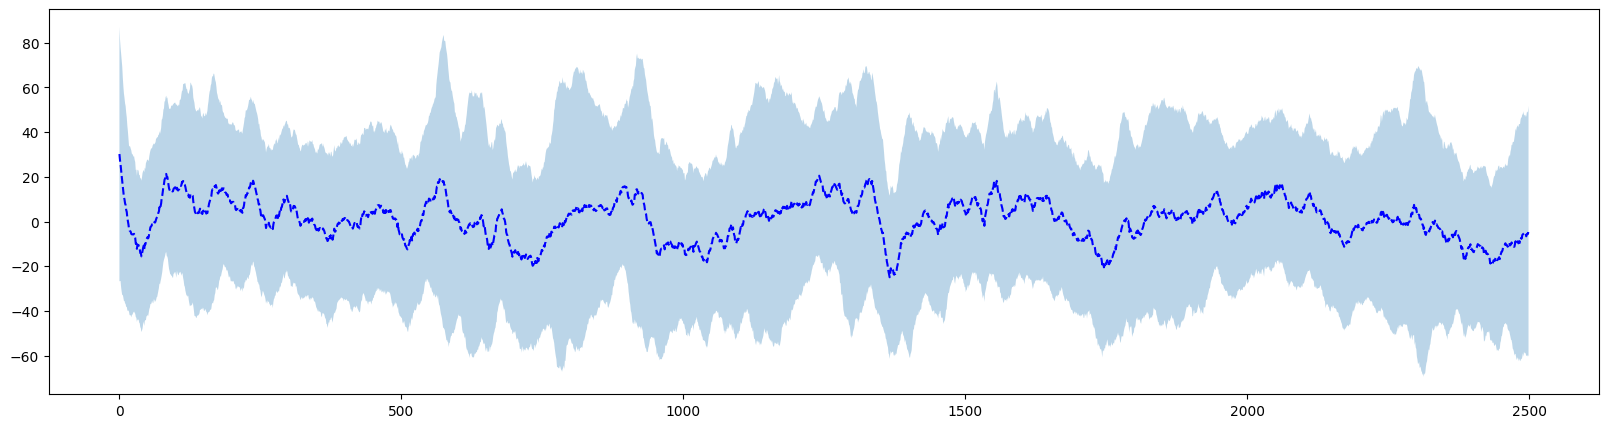

In [30]:
plt.figure(figsize=(20,5))
plt.plot(np.mean(CA1_channels,axis=0)[:2500], linestyle='dashed', color='blue')
plt.fill_between(range(len(np.mean(CA1_channels,axis=0)[:2500])), np.mean(CA1_channels,axis=0)[:2500]+2*np.std(CA1_channels,axis=0)[:2500],np.mean(CA1_channels,axis=0)[:2500]-2*np.std(CA1_channels,axis=0)[:2500],alpha=0.3)

In [105]:
# A highpass filter to isolate higher frequencies in each channel

CA1_filtered_channels = dsp.filter_signal(CA1_channels,2500,'highpass',(150,250), filter_type='iir',butterworth_order=3)


C:\Python Work Directory\neuromatch\Lib\site-packages\neurodsp\filt\filter.py:98: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
C:\Python Work Directory\neuromatch\Lib\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


In [32]:
print(CA1_filtered_channels.shape)

(50, 9585948)


### Comparison of a raw CA1 LFP with respect to higher frequencies

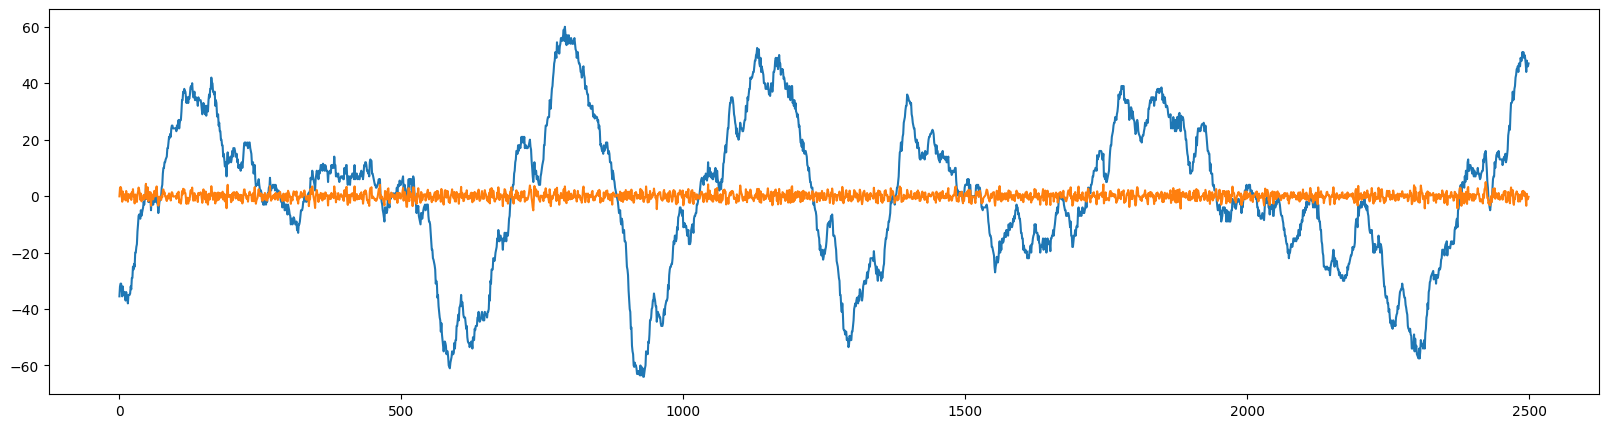

In [33]:
plt.figure(figsize=(20,5))
plt.plot(CA1_channels[0,:2500])
plt.plot(CA1_filtered_channels[0,:2500])

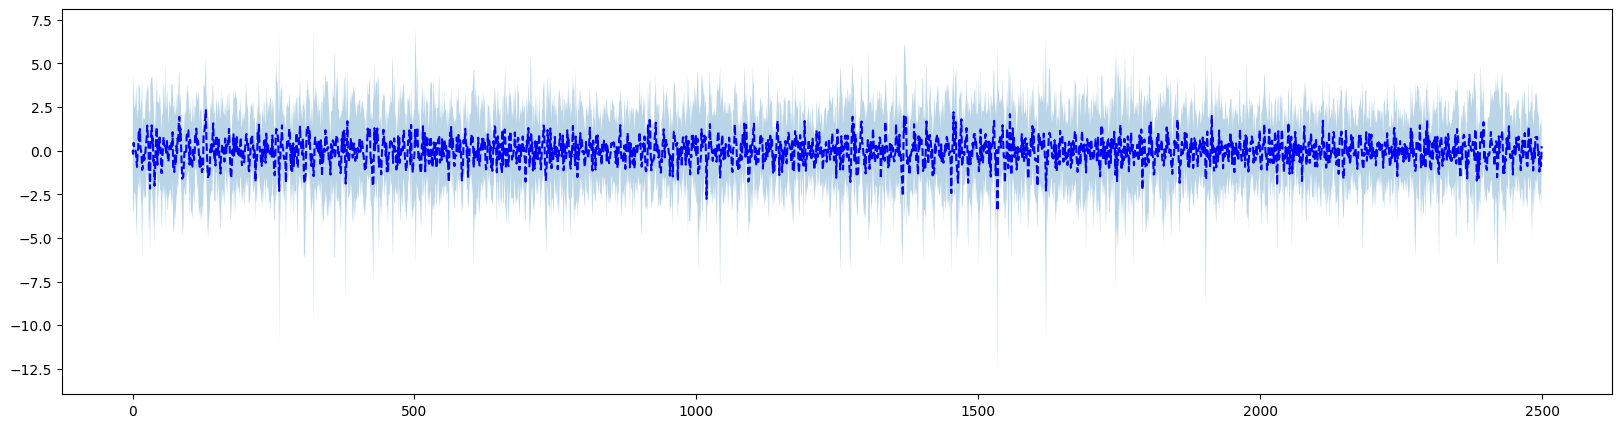

In [34]:
plt.figure(figsize=(20,5))
plt.plot(np.mean(CA1_filtered_channels,axis=0)[:2500],linestyle='dashed', color='blue')
plt.fill_between(range(len(np.mean(CA1_filtered_channels,axis=0)[:2500])), np.mean(CA1_filtered_channels,axis=0)[:2500]+2*np.std(CA1_filtered_channels,axis=0)[:2500],np.mean(CA1_filtered_channels,axis=0)[:2500]-2*np.std(CA1_filtered_channels,axis=0)[:2500],alpha=0.3)

In [37]:
# Root mean square function for calculating max ripple power
def rms (signal):
    rms = np.sqrt(np.mean(np.square(signal),axis=1))
    return rms

In [38]:
ripple_power = rms(CA1_filtered_channels)

In [108]:
optimum_channel = np.where(ripple_power==np.max(ripple_power))[0][0]
print(optimum_channel)

28


### Power spectrum after selecting the best CA1 channel

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Power Spectral Density'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency'>)

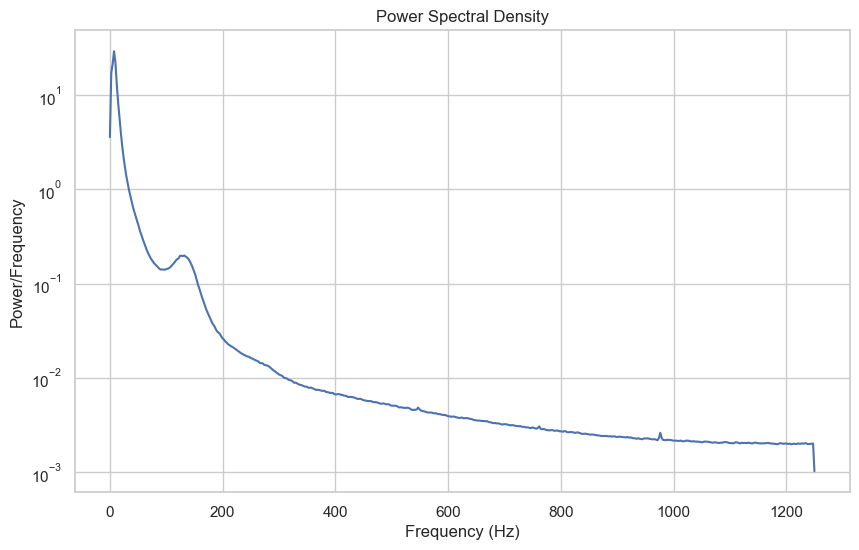

In [109]:
plot_power_spectrum(CA1_channels[optimum_channel,:],2500)

In [41]:
# Lowpass filter to cutoff frequencies above 200 Hz

filtered_LFP = dsp.filter_signal(CA1_channels[optimum_channel],2500,'lowpass',(None,200), filter_type='iir',butterworth_order=4)

C:\Python Work Directory\neuromatch\Lib\site-packages\neurodsp\filt\filter.py:98: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Power Spectral Density'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency'>)

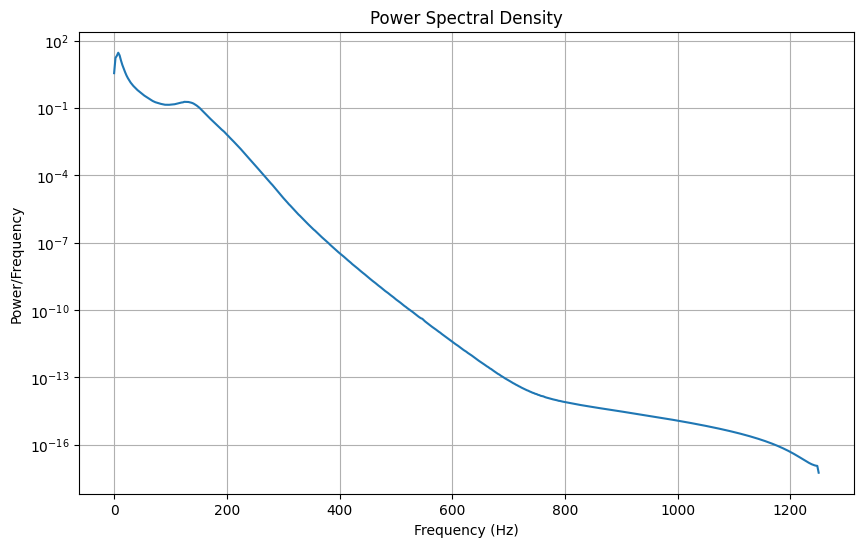

In [42]:
plot_power_spectrum(filtered_LFP,2500)

In [43]:
# Import Theta Cycle Extraction and Data Management Class Functions
from src.signal import *


In [44]:
# Intialize with selecting the optimum channel RAW LFP
wake_test_one = WakeSignal(CA1_channels[optimum_channel],2500,(5,12))

ic| 'No imf data, generating imfs....'
ic| 'No cycle data, extracting cycles....'


In [45]:
print(wake_test_one.mask_freq)

[465.65782893 122.34752697  32.86648872  10.97255493   5.81730007
   2.22773796]


<Axes: xlabel='Time (samples)'>

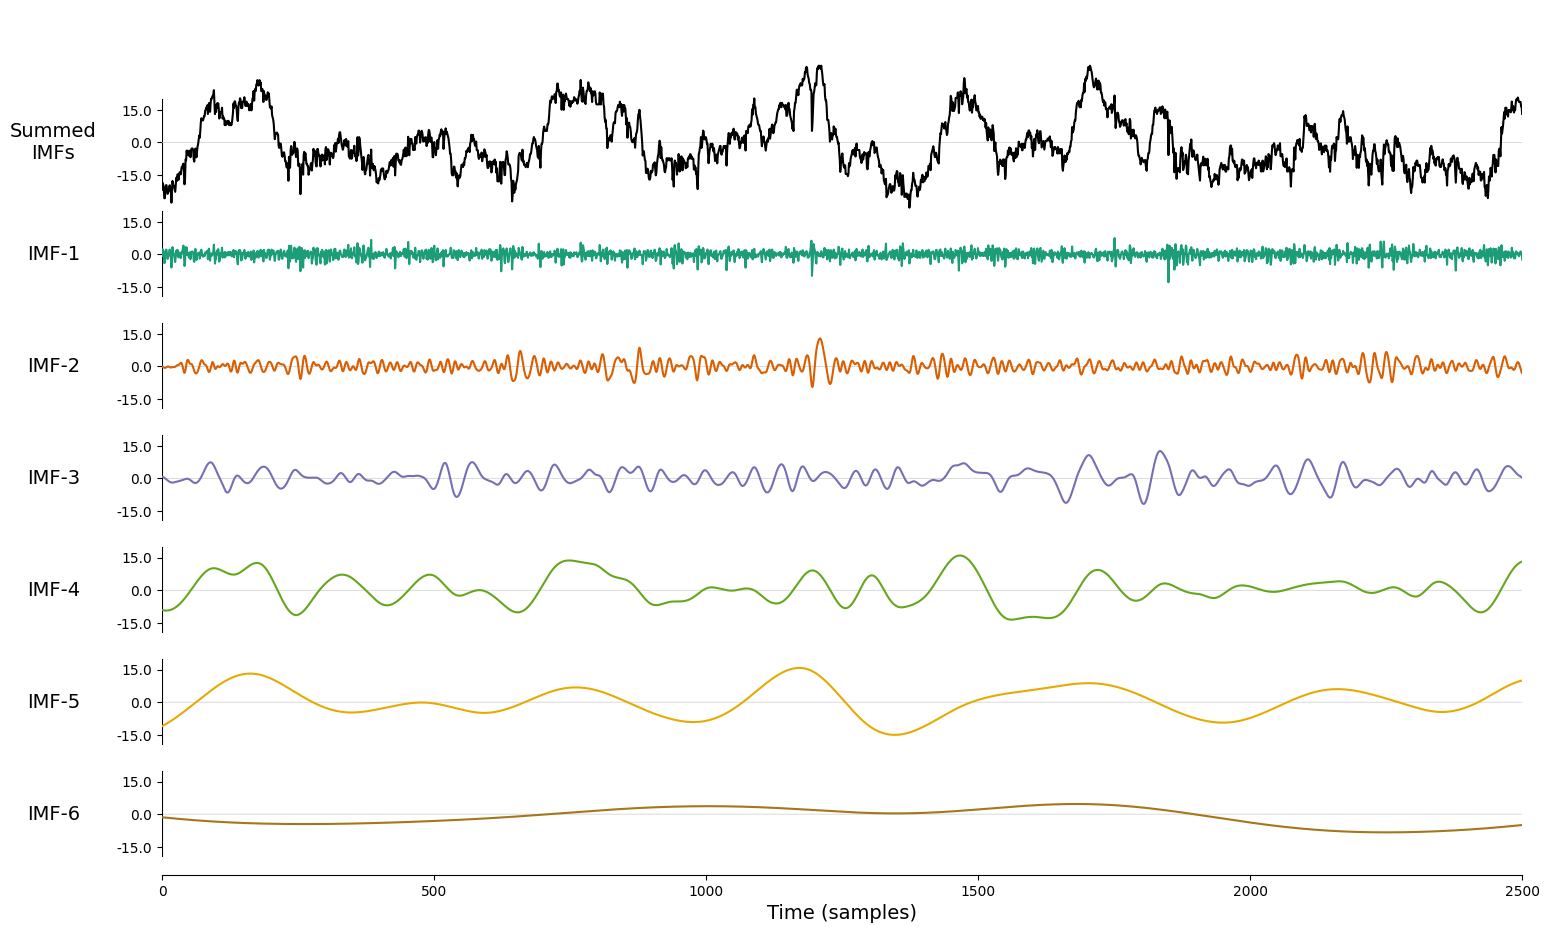

In [46]:
emd.plotting.plot_imfs(wake_test_one.imf[2500:5000])

In [47]:
# Extract cycles that satisfy thresholds
fpp_cycles_one = wake_test_one.get_fpp_cycles(frequencies=(15,120), band = 'gamma', mode = 'power')

In [48]:
print(fpp_cycles_one.shape)

(20594, 106, 19)


In [49]:
# Intialize with selecting the optimum channel RAW LFP minus the high frequency components using EMD
wake_test_two = WakeSignal(np.sum(wake_test_one.imf[:,1:],axis=1),2500,(5,12))

ic| 'No imf data, generating imfs....'
ic| 'No cycle data, extracting cycles....'


In [50]:
print(wake_test_two.mask_freq)

[121.78867184  28.13804014   9.68611622   4.66023819   1.91064721
   0.77893291]


<Axes: xlabel='Time (samples)'>

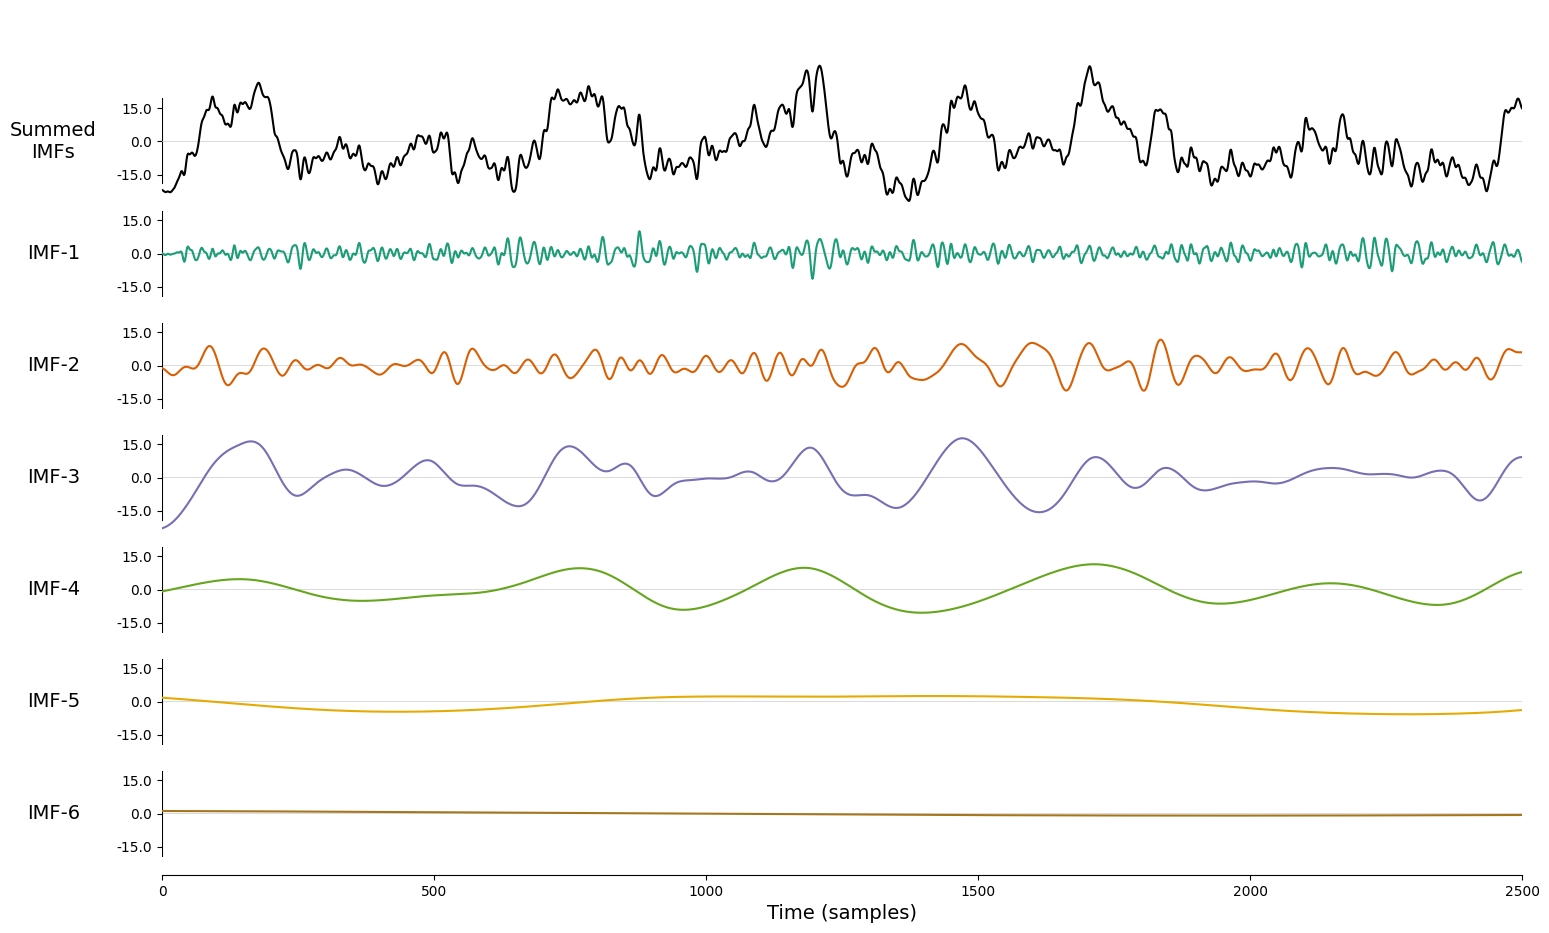

In [51]:
emd.plotting.plot_imfs(wake_test_two.imf[2500:5000])

In [52]:
fpp_cycles_two = wake_test_two.get_fpp_cycles(frequencies=(15,120), band = 'gamma', mode = 'power')

In [53]:
# Intialize with selecting the using low pass filtered LFP
wake_test_three = WakeSignal(filtered_LFP,2500,(5,12))
fpp_cycles_three = wake_test_three.get_fpp_cycles(frequencies=(15,120), band = 'gamma', mode = 'power')

ic| 'No imf data, generating imfs....'
ic| 'No cycle data, extracting cycles....'


In [54]:
print(wake_test_three.mask_freq)

[112.46894786  25.61606108   9.3118833    4.35792163   1.70965199
   0.74041585]


In [55]:
# Generate center of gravity peaks for each cycle
peaks_one = wake_test_one.peak_center_of_gravity()
peaks_two = wake_test_two.peak_center_of_gravity()
peaks_three = wake_test_three.peak_center_of_gravity()

In [84]:
# Generate all peaks from FPP topology
fpp_peaks_one = wake_test_one.get_fpp_peaks(frequencies=(15,120))
fpp_peaks_two = wake_test_two.get_fpp_peaks(frequencies=(15,120))
fpp_peaks_three = wake_test_three.get_fpp_peaks(frequencies=(15,120))

In [56]:
print(fpp_cycles_two.shape)
print(fpp_cycles_three.shape)

(18069, 106, 19)
(18951, 106, 19)


In [57]:
frequencies = np.arange(15,121,1)
angles = np.linspace(-180,180,19)
print(angles)

[-180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.   40.
   60.   80.  100.  120.  140.  160.  180.]


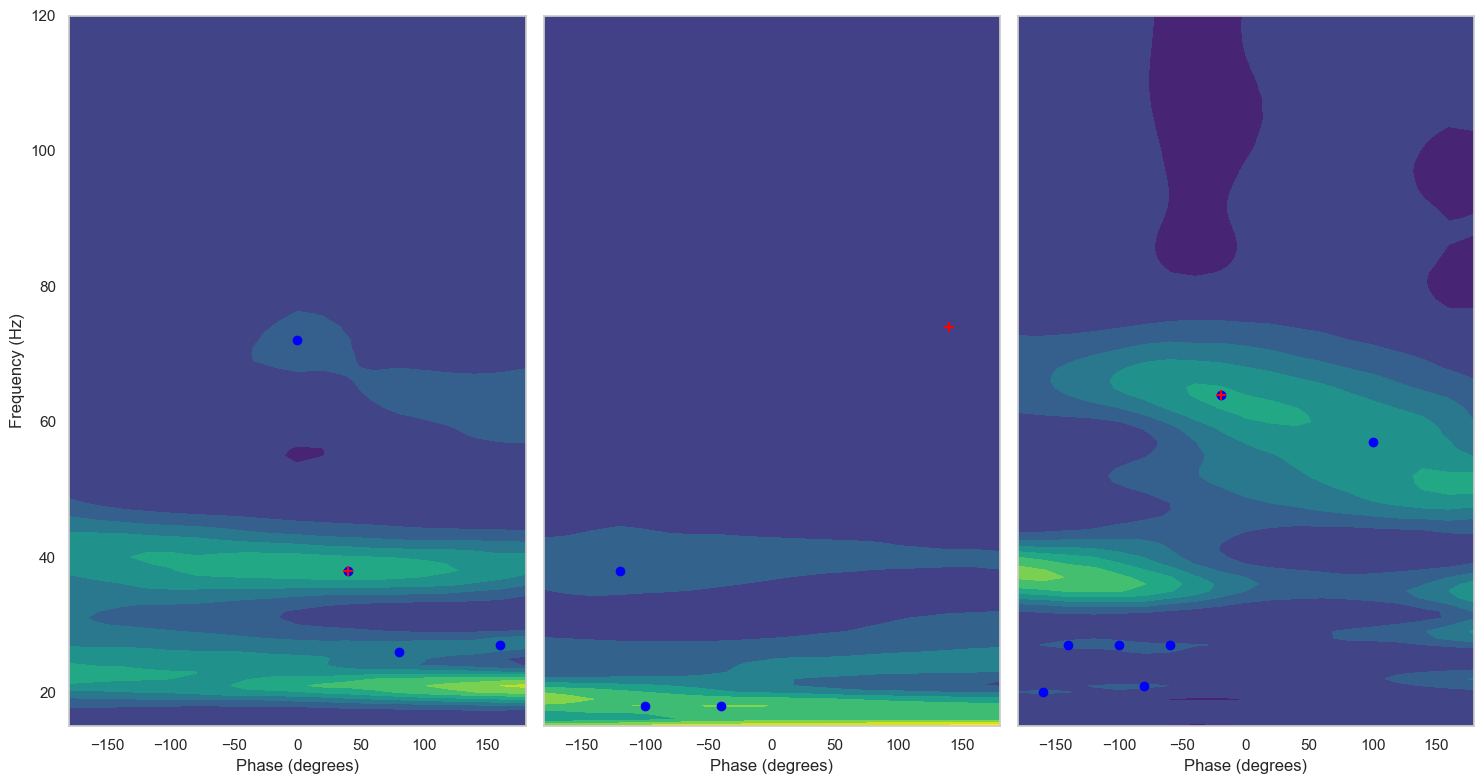

In [112]:
index = 12000
fig,ax = plt.subplots(1,3,figsize=(15,8), sharey=True)
ax[0].set_ylabel('Frequency (Hz)')
ax[0].contourf(angles,frequencies,fpp_cycles_one[index,:,:], vmin=-2, vmax=6,cmap ='viridis')
ax[0].scatter(fpp_peaks_one[index][:,1],fpp_peaks_one[index][:,0], color='blue')
ax[0].scatter(peaks_one[index,1],peaks_one[index,0], color='red',marker='+',s=50)
ax[1].contourf(angles,frequencies,fpp_cycles_two[index,:,:], vmin=-2, vmax=6,cmap ='viridis')
ax[1].scatter(fpp_peaks_two[index][:,1],fpp_peaks_two[index][:,0], color='blue')
ax[1].scatter(peaks_two[index,1],peaks_two[index,0], color='red', marker='+',s=50)
ax[2].contourf(angles,frequencies,fpp_cycles_three[index,:,:], vmin=-2, vmax=6,cmap ='viridis')
ax[2].scatter(fpp_peaks_three[index][:,1],fpp_peaks_three[index][:,0], color='blue')
ax[2].scatter(peaks_three[index,1],peaks_three[index,0], color='red', marker='+',s=50)
ax[0].set_xlabel('Phase (degrees)')
ax[1].set_xlabel('Phase (degrees)')
ax[2].set_xlabel('Phase (degrees)')
plt.tight_layout()

In [60]:
spectral_signatures_one = np.mean(fpp_cycles_one,axis=2)
spectral_signatures_two = np.mean(fpp_cycles_two,axis=2)
spectral_signatures_three = np.mean(fpp_cycles_three,axis=2)

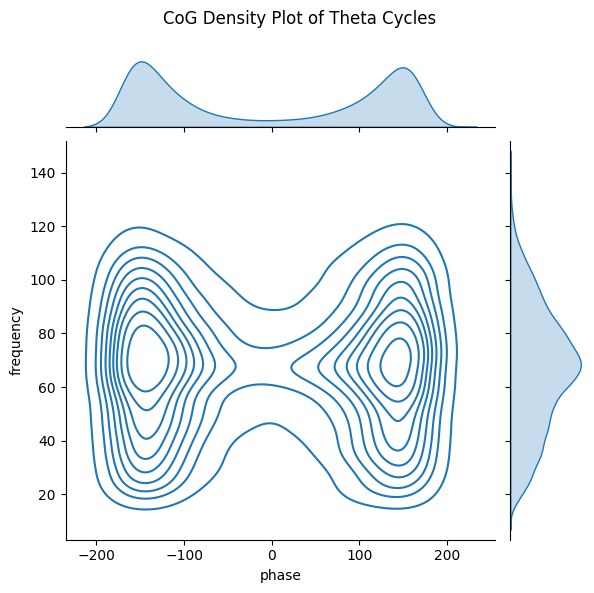

In [61]:
peaks_one_df = pd.DataFrame(columns=['frequency','phase'])
peaks_one_df['frequency'] = peaks_one[:,0]
peaks_one_df['phase'] = peaks_one[:,1]
g = sns.JointGrid(data=peaks_one_df, x="phase", y="frequency")
g = g.plot_joint(sns.kdeplot)
g = g.plot_marginals(sns.kdeplot, fill=True)
g.fig.suptitle("CoG Density Plot of Theta Cycles")
g.fig.subplots_adjust(top=0.9)

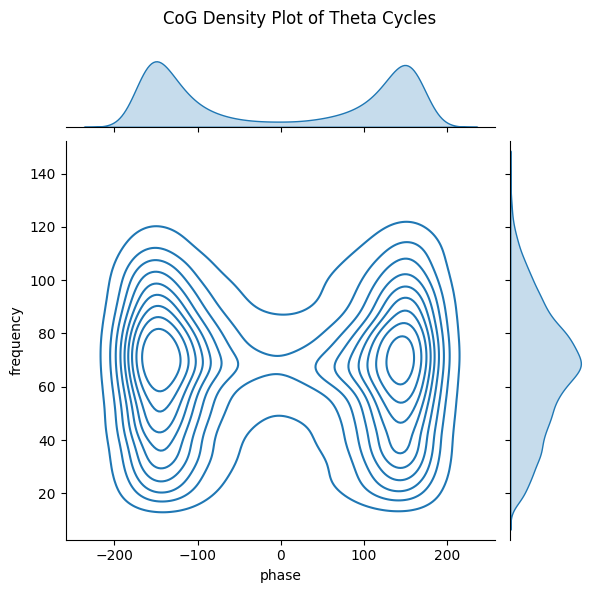

In [62]:
peaks_two_df = pd.DataFrame(columns=['frequency','phase'])
peaks_two_df['frequency'] = peaks_two[:,0]
peaks_two_df['phase'] = peaks_two[:,1]
g = sns.JointGrid(data=peaks_two_df, x="phase", y="frequency")
g = g.plot_joint(sns.kdeplot)
g = g.plot_marginals(sns.kdeplot, fill=True)
g.fig.suptitle("CoG Density Plot of Theta Cycles")
g.fig.subplots_adjust(top=0.9)

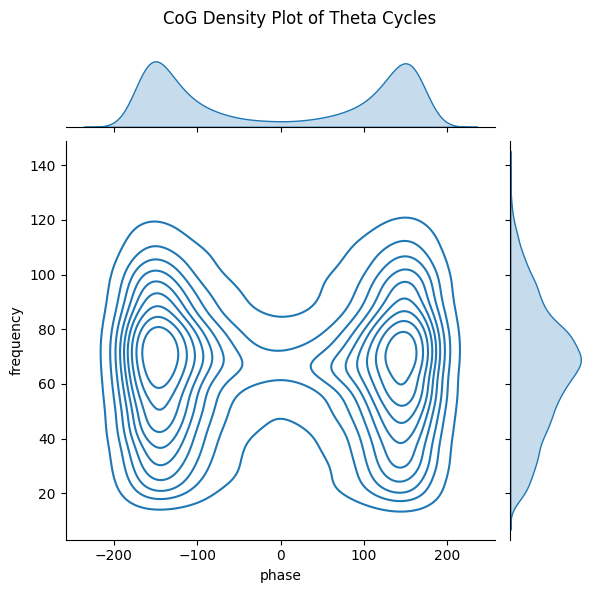

In [63]:
peaks_three_df = pd.DataFrame(columns=['frequency','phase'])
peaks_three_df['frequency'] = peaks_three[:,0]
peaks_three_df['phase'] = peaks_three[:,1]
g = sns.JointGrid(data=peaks_three_df, x="phase", y="frequency")
g = g.plot_joint(sns.kdeplot)
g = g.plot_marginals(sns.kdeplot, fill=True)
g.fig.suptitle("CoG Density Plot of Theta Cycles")
g.fig.subplots_adjust(top=0.9)

In [64]:
def find_peaks_bool_array(signals):
    """
    Find all relative maxima in an array of 1D signals and return a boolean array for each signal.

    Parameters:
    - signals: A 2D numpy array where each row represents a signal.

    Returns:
    - A 2D boolean array with the same shape as 'signals', where True indicates a peak and False otherwise
      for each signal in the input array.
    """
    num_signals, signal_length = signals.shape

    # Initialize a 2D boolean array with False values
    peaks_bool_array = np.zeros_like(signals, dtype=bool)

    for i in range(num_signals):
        # Find relative maxima indices using argrelmax for each signal
        maxima_indices = signal.argrelmax(signals[i])[0]

        # Set the indices of relative maxima to True for the current signal
        peaks_bool_array[i, maxima_indices] = True

    return peaks_bool_array

# Example usage with an array of signals:

In [65]:
freq_signatures_one = find_peaks_bool_array(spectral_signatures_one)*frequencies
freq_signatures_two = find_peaks_bool_array(spectral_signatures_two)*frequencies
freq_signatures_three = find_peaks_bool_array(spectral_signatures_three)*frequencies

freq_signatures_one = freq_signatures_one.flatten()
freq_signatures_two = freq_signatures_two.flatten()
freq_signatures_three =freq_signatures_three.flatten()

freq_signatures_one = freq_signatures_one[freq_signatures_one > 0]
freq_signatures_two = freq_signatures_two[freq_signatures_two > 0]
freq_signatures_three = freq_signatures_three[freq_signatures_three > 0]

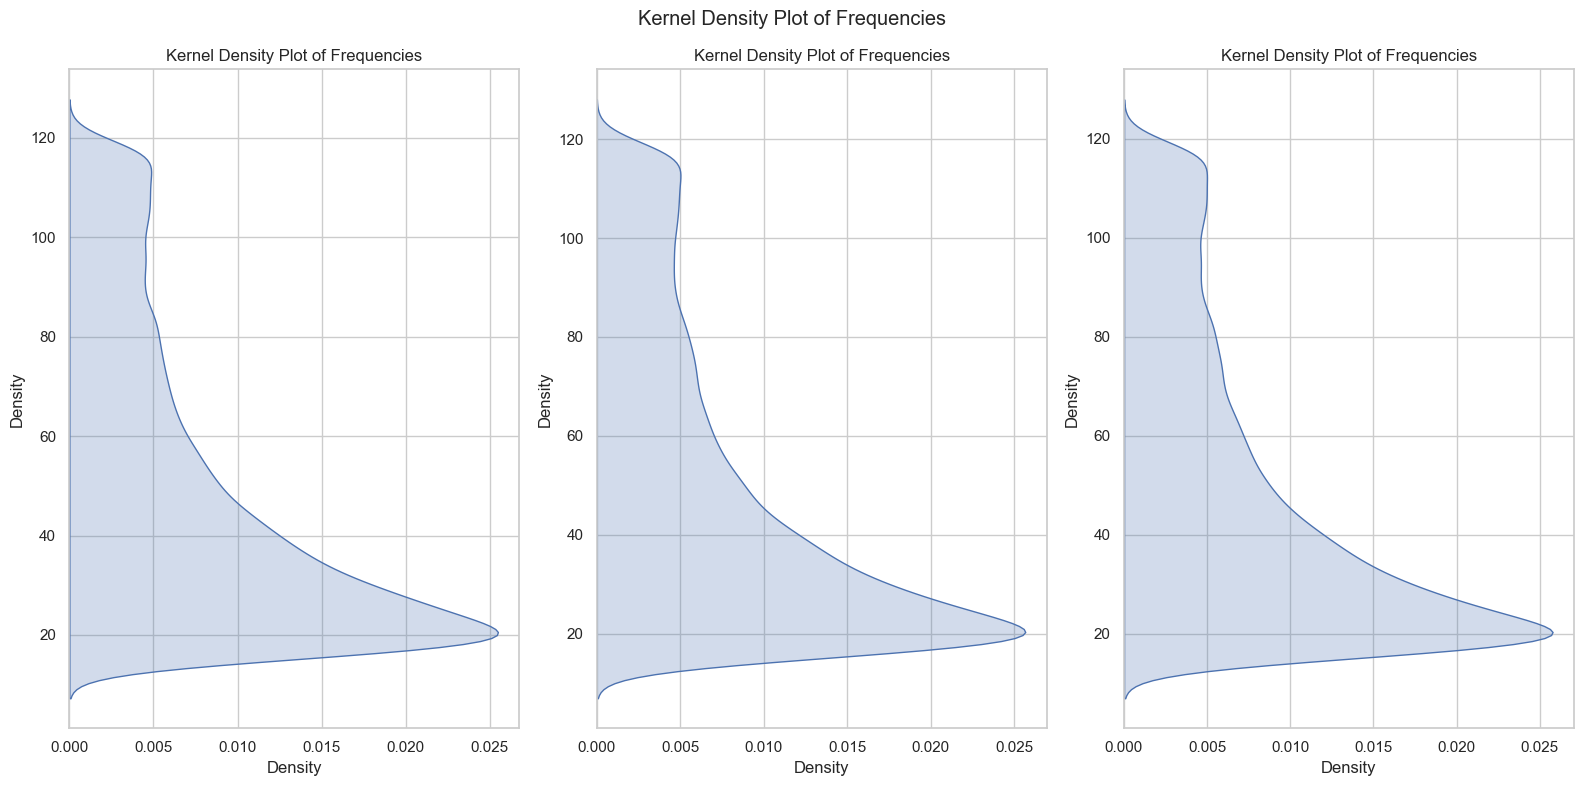

In [89]:
fig1, axes = plt.subplots(1, 3, figsize=(16, 8))  # Adjust the figure size as needed
sns.set(style="whitegrid")

sns.kdeplot(y=freq_signatures_one, ax=axes[0], fill=True)
axes[0].set_ylabel("Density")
axes[0].set_title("Kernel Density Plot of Frequencies")

sns.kdeplot(y=freq_signatures_two, ax=axes[1], fill=True)
axes[1].set_ylabel("Density")
axes[1].set_title("Kernel Density Plot of Frequencies")

sns.kdeplot(y=freq_signatures_three, ax=axes[2], fill=True)
axes[2].set_ylabel("Density")
axes[2].set_title("Kernel Density Plot of Frequencies")

fig1.suptitle('Kernel Density Plot of Frequencies')

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()